# WIDS HBN Datathon Analysis

Our team's goal is to train the best model from training dataset to predict ADHD and Sex. 

The Notebook can be divided into five parts:  
1. Imports & configuration  
2. Data loading  
3. Preprocessing pipelines  
4. Model comparison  
5. Prediction & Final submission  

In [124]:
# Standard library
import os
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd

# Pipeline utility
from sklearn.pipeline import Pipeline

# Preprocessing utilities
from sklearn.compose       import ColumnTransformer
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# Traditional ML models & selection
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection  import SelectKBest, f_classif
from xgboost                    import XGBClassifier

# Neural networks (scikit-learn)
from sklearn.neural_network     import MLPClassifier

# Model evaluation & search
from sklearn.model_selection    import (
    cross_val_score,
    cross_val_predict,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics            import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

# Deep learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models

import warnings

# suppress those pandas formatting RuntimeWarnings
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in (greater|less)"
)

# Plot
import matplotlib.pyplot as plt


In [18]:
# Confirm project paths
ROOT = Path().resolve()

# Define the sub-folders
TRAIN_NEW = ROOT / "TRAIN_NEW"
TRAIN_OLD = ROOT / "TRAIN_OLD"
TEST      = ROOT / "TEST"

In [20]:
# Read train data
cat_new   = pd.read_excel( TRAIN_NEW / "TRAIN_CATEGORICAL_METADATA_new.xlsx", engine="openpyxl")
quant_new = pd.read_excel( TRAIN_NEW / "TRAIN_QUANTITATIVE_METADATA_new.xlsx", engine="openpyxl")
func_new  = pd.read_csv(  TRAIN_NEW / "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv", index_col=0)
soln_new  = pd.read_excel( TRAIN_NEW / "TRAINING_SOLUTIONS.xlsx", engine="openpyxl")

print(cat_new.shape, quant_new.shape, func_new.shape, soln_new.shape)
func_new.head()




(1213, 10) (1213, 19) (1213, 19900) (1213, 3)


,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,0.470063,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,0.276350,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,0.378557,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,0.259596,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,0.331445,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


In [22]:
# 1. Make sure participant_id is actually the index in func_new
func_new.index.name = "participant_id"

# 2. Merge metadata + solutions
meta = (
    cat_new
    .merge(quant_new,   on="participant_id", how="inner")
    .merge(soln_new,    on="participant_id", how="inner")
)

print("meta shape:", meta.shape)          # should be (1213, 10+19+3 = 32)
print("func shape:", func_new.shape)      # (1213, 19900)

# 3. Final full training table
train = meta.join(func_new, on="participant_id", how="inner")
print("full train shape:", train.shape)   # expect (1213, 32+19900 = 19932)
train.head(3)


meta shape: (1213, 30)
func shape: (1213, 19900)
full train shape: (1213, 19930)


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,...,-0.047477,-0.096450,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,...,-0.143218,-0.276464,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,...,-0.133778,-0.108588,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182


In [24]:
# 1. Show the first 10 column names (metadata + targets)
print("First 10 columns:")
print(train.columns[:10].tolist(), "\n")

# 2. Show the last 10 column names (functional features)
print("Last 10 columns:")
print(train.columns[-10:].tolist(), "\n")

# 3. Confirm counts
n_meta = len(cat_new.columns) + len(quant_new.columns) + 2   # +2 for ADHD_Outcome & Sex_F
n_func = func_new.shape[1]
print(f"Metadata+targets columns: {n_meta}")
print(f"Functional-connectome columns: {n_func}")
print(f"Total columns in train: {train.shape[1]}")


First 10 columns:
['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ'] 

Last 10 columns:
['195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn', '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn', '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn', '198throw_199thcolumn'] 

Metadata+targets columns: 31
Functional-connectome columns: 19900
Total columns in train: 19930


In [26]:
# Check for missing values
missing = train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.head(10)


MRI_Track_Age_at_Scan               360
Barratt_Barratt_P2_Occ              222
Barratt_Barratt_P2_Edu              198
PreInt_Demos_Fam_Child_Race          54
PreInt_Demos_Fam_Child_Ethnicity     43
Barratt_Barratt_P1_Occ               31
ColorVision_CV_Score                 23
Barratt_Barratt_P1_Edu               15
EHQ_EHQ_Total                        13
APQ_P_APQ_P_ID                       12
dtype: int64

In [28]:
# 1. Categorical metadata (all of cat_new except the ID)
cat_cols = cat_new.columns.drop("participant_id").tolist()

# 2. Quantitative metadata (all of quant_new except the ID)
quant_cols = quant_new.columns.drop("participant_id").tolist()

# 3. Functional-connectome features (all columns of func_new)
func_cols = func_new.columns.tolist()

# 4. Targets and identifier
target_cols = ["ADHD_Outcome", "Sex_F"]
id_col      = "participant_id"

# 5. Quick check
print("Categorical metadata columns (n={}):".format(len(cat_cols)), cat_cols, "\n")
print("Quantitative metadata columns (n={}):".format(len(quant_cols)), quant_cols, "\n")
print("Functional features count:", len(func_cols))


Categorical metadata columns (n=9): ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ'] 

Quantitative metadata columns (n=18): ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'] 

Functional features count: 19900


In [30]:
# Drop the ID and target columns from train → Got feature matrix
X = train.drop(columns=[id_col] + target_cols)

# Define two target vectors
y_adhd = train["ADHD_Outcome"]
y_sex  = train["Sex_F"]

# Quick sanity check
print("X shape:", X.shape)
print("y_adhd shape:", y_adhd.shape)
print("y_sex shape:", y_sex.shape)


X shape: (1213, 19927)
y_adhd shape: (1213,)
y_sex shape: (1213,)


In [32]:
# Cast categoricals in X to strings
X[cat_cols] = X[cat_cols].astype(str)
print("dtypes of cat_cols now:\n", X[cat_cols].dtypes)

# Categorical Pipeline
cat_pipeline = Pipeline([
    # 2a) Fill any NaN in categorical fields with the string "MISSING"
    ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),

    # 2b) One-hot encode each category level.
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


dtypes of cat_cols now:
 Basic_Demos_Enroll_Year             object
Basic_Demos_Study_Site              object
PreInt_Demos_Fam_Child_Ethnicity    object
PreInt_Demos_Fam_Child_Race         object
MRI_Track_Scan_Location             object
Barratt_Barratt_P1_Edu              object
Barratt_Barratt_P1_Occ              object
Barratt_Barratt_P2_Edu              object
Barratt_Barratt_P2_Occ              object
dtype: object


In [34]:
# Quantitive Pipeline
quant_pipeline = Pipeline([
    # 3a) Fill missing numeric values with the median of that column
    ("impute", SimpleImputer(strategy="median")),

    # 3b) Scale to mean=0, std=1 so different units don’t dominate
    ("scale", StandardScaler()),
])


In [53]:
# Functional-Connectome Pipeline
func_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler()),
    # Reduce 19900 → 300 components with randomized SVD
    ("pca",    PCA(n_components=300, svd_solver="randomized", random_state=615)),
])


In [55]:
preprocessor = ColumnTransformer([
    ("cat",   cat_pipeline,   cat_cols),
    ("quant", quant_pipeline, quant_cols),
    ("func",  func_pipeline,  func_cols),
], 
    remainder="drop",
    n_jobs=-1
)

In [62]:
X_sample = X.sample(n=600, random_state=615)            # grab random 600 rows
X_proc   = preprocessor.fit_transform(X_sample)
print("Input shape:   ", X_sample.shape)
print("Output shape:  ", X_proc.shape)


Input shape:    (600, 19927)
Output shape:   (600, 384)


In [65]:
# logistic‐regression
y_adhd_sample = y_adhd.loc[X_sample.index]
y_sex_sample = y_sex.loc[X_sample.index]

# Define two pipelines
pipe_adhd_lr = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_sex_lr = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# 5-fold cross-validation (AUC)
scores_adhd = cross_val_score(pipe_adhd_lr, X_sample, y_adhd_sample, 
                              cv=5, scoring="roc_auc", n_jobs=-1)

scores_sex = cross_val_score(pipe_sex_lr, X_sample, y_sex_sample, 
                             cv=5, scoring="roc_auc", n_jobs=-1)

print("ADHD AUC per fold:", scores_adhd)
print("Mean ADHD AUC: {:.4f}".format(scores_adhd.mean()))

print("Sex AUC per fold:", scores_sex)
print("Mean Sex AUC: {:.4f}".format(scores_sex.mean()))

ADHD AUC per fold: [0.63543004 0.69030809 0.58215661 0.65821566 0.62708601]
Mean ADHD AUC: 0.6386
Sex AUC per fold: [0.81837607 0.73260073 0.73199023 0.79932078 0.84439642]
Mean Sex AUC: 0.7853


In [101]:
# Random Forest with Univariate Feature-Selection
pipe_fs_rf = Pipeline([
    ("pre",      preprocessor),
    ("select",   SelectKBest(f_classif, k=300)),
    ("rf",       RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=615)),
])

scores = cross_val_score(pipe_fs_rf, X_sample, y_adhd_sample, cv=10,
                         scoring="roc_auc", n_jobs=-1)
scores_sex = cross_val_score(pipe_fs_rf, X_sample, y_sex_sample, cv=10,
                         scoring="roc_auc", n_jobs=-1)
print("Feature-select RF (ADHD) AUC:", scores, "mean:", scores.mean())
print("Feature-select RF (Sex) AUC:", scores_sex, "mean:", scores_sex.mean())

Feature-select RF (ADHD) AUC: [0.73299101 0.91912709 0.81514763 0.88189987 0.82284981 0.89473684
 0.79396662 0.86264442 0.68035944 0.77021823] mean: 0.8173940949935815
Feature-select RF (Sex) AUC: [0.62148962 0.65934066 0.50976801 0.75457875 0.69352869 0.7026862
 0.69108669 0.81013431 0.744375   0.755     ] mean: 0.6941987942612943


In [97]:
# Build PCA+XGBoost pipeline
pipe_xgb_pca = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBClassifier(
        tree_method="hist",    # histogram algorithm
        device="cuda",       
        n_estimators=1000,
        learning_rate=0.05,
        random_state=615,
        eval_metric="logloss"  
    )),
])

# Evaluate with 5-fold CV
scores = cross_val_score(
    pipe_xgb_pca, X_sample, y_adhd_sample,
    cv=5, scoring="roc_auc", n_jobs=-1
)

scores_sex = cross_val_score(
    pipe_xgb_pca, X_sample, y_sex_sample,
    cv=10, scoring="roc_auc", n_jobs=-1
)

print("XGBoost+PCA AUC per fold (ADHD):", scores)
print("Mean AUC:", scores.mean())

print("XGBoost+PCA AUC per fold (Sex):", scores_sex)
print("Mean AUC:", scores_sex.mean())

XGBoost+PCA AUC per fold (ADHD): [0.84403081 0.82092426 0.87516046 0.8241335  0.76668806]
Mean AUC: 0.8261874197689346
XGBoost+PCA AUC per fold (Sex): [0.70695971 0.62393162 0.51037851 0.7985348  0.69474969 0.68742369
 0.65323565 0.67399267 0.67625    0.74625   ]
Mean AUC: 0.6771706349206349


In [103]:
# Use scikit-learn’s MLPClassifier
pipe_mlp_tuned = Pipeline([
    ("pre", preprocessor),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256,128,64),   
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,           
        alpha=1e-4,                        
        batch_size=32,
        max_iter=1000,                      
        early_stopping=True,                
        n_iter_no_change=20,
        validation_fraction=0.1,
        random_state=615,
        verbose=False
    )),
])

scores_mlp_tuned = cross_val_score(
    pipe_mlp_tuned, X_sample, y_adhd_sample,
    cv=5, scoring="roc_auc", n_jobs=-1
)

scores_mlp_sex = cross_val_score(
    pipe_mlp_tuned, X_sample, y_sex_sample,
    cv=5, scoring="roc_auc", n_jobs=-1
)

print("Tuned MLP AUC per fold(ADHD):", scores_mlp_tuned)
print("Mean AUC:", scores_mlp_tuned.mean())

print("Tuned MLP AUC per fold(Sex):", scores_mlp_sex)
print("Mean AUC:", scores_mlp_sex.mean())

Tuned MLP AUC per fold(ADHD): [0.4457638  0.55840822 0.57284981 0.53080873 0.45956354]
Mean AUC: 0.5134788189987163
Tuned MLP AUC per fold(Sex): [0.67002442 0.57967033 0.62942613 0.61006483 0.60852115]
Mean AUC: 0.6195413724898133


In [112]:
# Which model to choose for prediction
models = {
    "Logistic": Pipeline([("pre", preprocessor),
                          ("clf", LogisticRegression(max_iter=1000))]),

    "RF": Pipeline([("pre", preprocessor),
                          ("sel", SelectKBest(f_classif, k=500)),
                          ("clf", RandomForestClassifier(n_estimators=1000,
                                                         class_weight="balanced",
                                                         n_jobs=-1, random_state=615))]),

    "XGB+PCA": Pipeline([("pre", preprocessor),
                         ("clf", XGBClassifier(tree_method="hist",
                                               device="cuda",
                                               n_estimators=1000,
                                               learning_rate=0.01,
                                               random_state=615,
                                               eval_metric="logloss"))]),

    "MLP Tuned": Pipeline([("pre", preprocessor),
                           ("mlp", MLPClassifier(hidden_layer_sizes=(256,128,64),
                                                  activation="relu",
                                                  solver="adam",
                                                  learning_rate_init=1e-3,
                                                  alpha=1e-4,
                                                  batch_size=32,
                                                  max_iter=1000,
                                                  early_stopping=True,
                                                  n_iter_no_change=20,
                                                  validation_fraction=0.1,
                                                  random_state=615))])
}



In [114]:
# Compare on ADHD_Outcome
print("=== ADHD_Outcome: 5-fold ROC AUC ===")
for name, mdl in models.items():
    scores = cross_val_score(mdl, X, y_adhd, cv=5,
                             scoring="roc_auc", n_jobs=-1)
    print(f"{name:10s} →", np.round(scores,5), " mean=", round(scores.mean(),5))
print()

# Compare on Sex_F
print("=== Sex_F: 5-fold metrics ===")
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=615)

for name, mdl in models.items():
    y_prob = cross_val_predict(mdl, X, y_sex, cv=kf,
                               method="predict_proba", n_jobs=-1)[:,1]
    y_pred = (y_prob > 0.5).astype(int)
    results.append({
        "Model":     name,
        "Accuracy":  accuracy_score( y_sex, y_pred),
        "Precision": precision_score(y_sex, y_pred),
        "Recall":    recall_score(   y_sex, y_pred),
        "ROC AUC":   roc_auc_score(  y_sex, y_prob)
    })

df_sex = pd.DataFrame(results).set_index("Model")
display(df_sex)

=== ADHD_Outcome: 5-fold ROC AUC ===
Logistic   → [0.77506 0.79346 0.72493 0.78543 0.76387]  mean= 0.76855
RF         → [0.83497 0.82855 0.77046 0.88855 0.81238]  mean= 0.82698
XGB+PCA    → [0.844   0.84908 0.7606  0.86985 0.82475]  mean= 0.82966
MLP Tuned  → [0.62063 0.56228 0.49038 0.52259 0.6315 ]  mean= 0.56547

=== Sex_F: 5-fold metrics ===


,Accuracy,Precision,Recall,ROC AUC
Model,,,,
Logistic,0.726298,0.614754,0.540865,0.754746
RF,0.676834,0.800000,0.076923,0.709290
XGB+PCA,0.673537,0.568493,0.199519,0.652404
MLP Tuned,0.676010,0.543396,0.346154,0.677351


In [116]:
# for ADHD, I choose XGBoost+PCA
# for sex, I choose logistic regression
# ADHD final pipeline
pipe_adhd_final = Pipeline([
    ("pre", preprocessor),
    ("xgb", XGBClassifier(
        tree_method="hist",
        device="cuda",
        n_estimators=1000,          # more trees
        max_depth=6,               # slightly deeper
        learning_rate=0.01,        # slower learning
        subsample=0.8,             # regularize by row sampling
        colsample_bytree=0.8,      # regularize by feature sampling
        random_state=615,
        eval_metric="logloss"
    )),
])
pipe_adhd_final.fit(X, y_adhd)

# Sex final pipeline
pipe_sex_final = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        class_weight="balanced", 
        C=0.5,                    
        max_iter=2000,
        random_state=615
    )),
])
pipe_sex_final.fit(X, y_sex)


Pipeline(steps=[('pre',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Basic_Demos_Enroll_Year',
                                                   'Basic_Demos_Study_Site',
                                                   'PreInt_Demos_Fam_Child_Ethnicity',
                                                   'PreInt_Demos_Fam_Child_Race',
                                                   'MRI_Trac...
                                                   '0throw_18thcolumn',
                                                   '0throw_19thcolumn',
                                                   '0throw_20thcolumn',
                                                   '0throw_21thcolumn',
                                                   '0throw_22thcolumn',
                                                   '0throw_23thcolumn',
                                                   '0throw_24thcolumn',
                                                   '0throw_25thcolumn',
                                                   '0throw_26thcolumn',
                                                   '0throw_27thcolumn',
                                                   '0throw_28thcolumn',
                                                   '0throw_29thcolumn',
                                                   '0throw_30thcolumn', ...])])),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=2000, random_state=615))])

In [118]:
# Test
# 1. Define the TEST path
TEST_DIR = Path().resolve() / "TEST"

test_cat   = pd.read_excel(TEST_DIR / "TEST_CATEGORICAL.xlsx",          engine="openpyxl")
test_quant = pd.read_excel(TEST_DIR / "TEST_QUANTITATIVE_METADATA.xlsx", engine="openpyxl")
test_func  = pd.read_csv( TEST_DIR / "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv",
                          index_col=0)

# 2. Merge categorical + quantitative metadata
test_meta = test_cat.merge(test_quant, on="participant_id", how="inner")

# 3. Now join the connectome matrix (participant_id is the index of test_func)
test_full = test_meta.join(test_func, on="participant_id", how="inner")

# 4. Separate IDs from features
test_ids = test_full["participant_id"]
X_test   = test_full.drop(columns=["participant_id"])

# 5. Quick check
print("Test features shape:", X_test.shape)
test_full.head(3)


Test features shape: (304, 19927)


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987


In [120]:
# Predict on TEST set
adhd_probs = pipe_adhd_final.predict_proba(X_test)[:,1]
sex_probs  = pipe_sex_final.predict_proba(X_test)[:,1]

# Binary labels @ 0.5
adhd_pred = (adhd_probs > 0.5).astype(int)
sex_pred  = (sex_probs  > 0.5).astype(int)

# Build submission csv
submission = pd.DataFrame({
    "participant_id": test_ids,
    "ADHD_Outcome":   adhd_pred,
    "Sex_F":          sex_pred
})

display(submission.head())
submission.to_csv("wids_datathon_final_submission.csv", index=False)
print("Saved wids_datathon_final_submission.csv")

D:\Anaconda\Lib\site-packages\xgboost\core.py:729: UserWarning: [22:41:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,1,1
3,LZfeAb1xMtql,1,1
4,EnFOUv0YK1RG,1,0


Saved wids_datathon_final_submission.csv


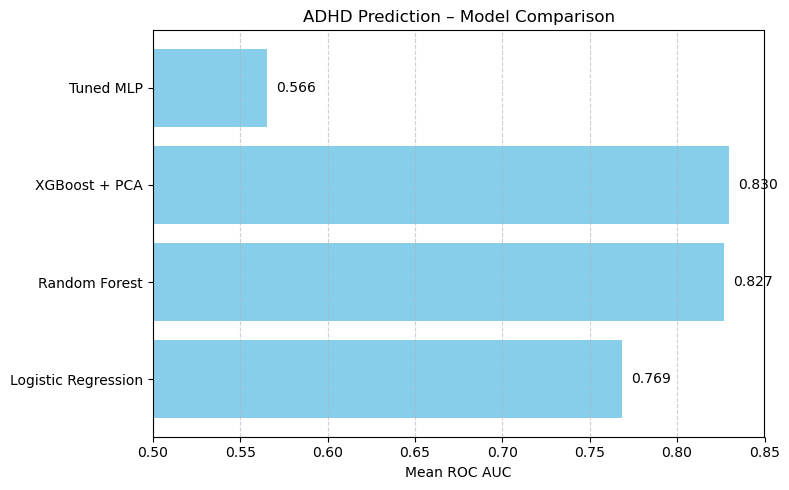

In [126]:
models = ["Logistic Regression", "Random Forest", "XGBoost + PCA", "Tuned MLP"]
auc_scores = [0.7686, 0.8270, 0.8297, 0.5655]

plt.figure(figsize=(8, 5))
bars = plt.barh(models, auc_scores, color="skyblue")
plt.xlabel("Mean ROC-AUC")
plt.title("ADHD Prediction – Model Comparison")
plt.xlim(0.5, 0.85)
for bar, auc in zip(bars, auc_scores):
    plt.text(auc + 0.005, bar.get_y() + bar.get_height()/2, f"{auc:.3f}", va='center')
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

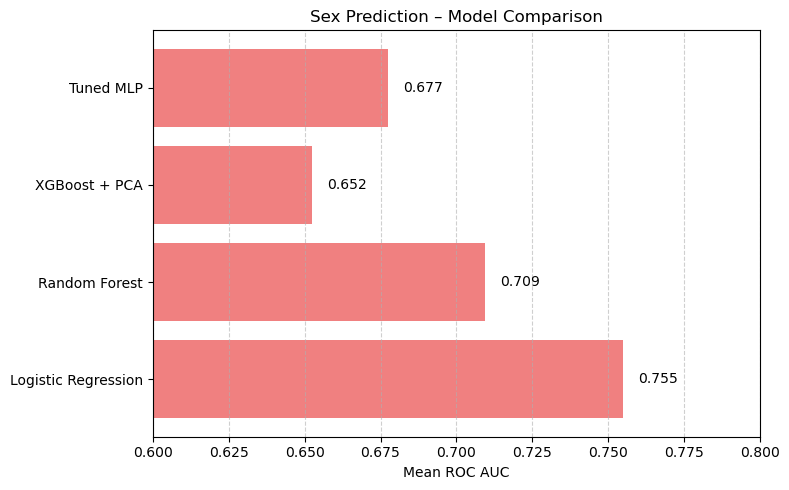

In [128]:
models = ["Logistic Regression", "Random Forest", "XGBoost + PCA", "Tuned MLP"]
auc_sex = [0.7547, 0.7093, 0.6524, 0.6774]

plt.figure(figsize=(8, 5))
bars = plt.barh(models, auc_sex, color="lightcoral")
plt.xlabel("Mean ROC AUC")
plt.title("Sex Prediction – Model Comparison")
plt.xlim(0.6, 0.8)
for bar, auc in zip(bars, auc_sex):
    plt.text(auc + 0.005, bar.get_y() + bar.get_height()/2, f"{auc:.3f}", va='center')
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()